# Predict Turbofan Degradation

In this tutorial, build a machine learning application to predict turbofan engine degradation. This application is structured into three important steps:

- Prediction Engineering
- Feature Engineering
- Machine Learning

In the first step, create new labels from the data by using [Compose](https://compose.alteryx.com/). In the second step, generate features for the labels by using [Featuretools](https://docs.featuretools.com/). In the third step, search for the best machine learning pipeline using [EvalML](https://evalml.alteryx.com/). After working through these steps, you should understand how to build machine learning applications for real-world problems like forecasting demand.

In [1]:
from demo.turbofan_degredation import load_sample
from matplotlib.pyplot import subplots
import composeml as cp
import featuretools as ft
import evalml

Use a dataset provided by [NASA](https://www.kaggle.com/behrad3d/nasa-cmaps) simulating turbofan engine degradation. In the dataset, there is data about engines that have been monitored over time. Each engine had operational settings and sensor measurements recorded over a number of cycles. The remaining useful life (RUL) is the amount of cycles an engine has left before it needs maintenance. What makes this dataset special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time. The model you build in this tutorial predicts RUL.

In [2]:
df = load_sample()
df.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time
id,,,,,,,,,,,,,,,,,,,,,
270,1,271,0.0010,0.0018,100.0,518.67,643.01,1591.11,1395.60,14.62,...,2388.12,8157.56,8.3141,0.03,393,2388,100.0,39.26,23.5280,2000-01-02 21:00:00
401,2,81,0.0004,0.0000,100.0,518.67,642.88,1581.74,1398.46,14.62,...,2387.98,8134.70,8.4092,0.03,392,2388,100.0,39.08,23.3215,2000-01-03 18:50:00
810,3,191,41.9983,0.8400,100.0,445.00,549.13,1352.21,1122.64,3.91,...,2388.18,8098.80,9.2919,0.02,330,2212,100.0,10.64,6.4525,2000-01-06 15:00:00
66,1,67,35.0054,0.8400,100.0,449.44,555.43,1351.45,1109.90,5.48,...,2387.89,8062.45,9.3215,0.02,333,2223,100.0,14.90,9.0315,2000-01-01 11:00:00
328,2,8,0.0023,0.0019,100.0,518.67,642.23,1576.51,1391.71,14.62,...,2388.07,8135.66,8.3894,0.03,392,2388,100.0,38.95,23.4243,2000-01-03 06:40:00


## Prediction Engineering

> Which range is the RUL of a turbofan engine in?

In this prediction problem, you want to group the RUL data into ranges, then predict which range the RUL is in. You can make variations in the ranges to create different prediction problems. For example, the ranges could be manually defined (0 - 150, 150 - 300, etc.) or based on the quartiles from historical observations. Bin the RUL to make variations, helping you explore different scenarios that are crucial for making better decisions.

### Defining the Labeling Function

Let’s start by defining the labeling function of an engine that calculates the RUL. Given that engines run all the way until failure, the RUL is just the remaining number of observations. Our labeling function will be used by a label maker to extract the training examples.

In [3]:
def rul(ds):
    return len(ds) - 1

### Representing the Prediction Problem

Represent the prediction problem by creating a label maker with the following parameters:

- The `target_entity` as the column for the engine ID, since you want to process records for each engine.
- The `labeling_function` as the function you defined previously.
- The `time_index` as the column for the event time.

In [4]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    labeling_function=rul,
    time_index='time',
)

### Finding the Training Examples

Run a search to get the training examples by using the following parameters:

- The records sorted by the event time, since the search expects the records to be sorted chronologically. Otherwise, an error occurs.
- `num_examples_per_instance` as the number of training examples to find for each engine.
- `minimum_data` as the amount of data to use to make features for the first training example.
- `gap` as the number of rows to skip between examples. This is done to cover different points in time of an engine.

You can easily tweak these parameters and run more searches for training examples as the requirements of our model change.

In [5]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=20,
    minimum_data=5,
    gap=20,
    verbose=False,
)

lt.head()

,engine_no,time,rul
0,1,2000-01-01 02:10:00,153
1,1,2000-01-01 10:20:00,133
2,1,2000-01-01 15:30:00,113
3,1,2000-01-02 00:20:00,93
4,1,2000-01-02 06:00:00,73


The output from the search is a label times table with three columns:

- The engine ID associated to the records. There can be many training examples generated from each engine.
- The event time of the engine. This is also known as a cutoff time for building features. Only data that existed beforehand is valid to use for predictions.
- The value of the RUL. This is calculated by the labeling function.

At this point, you only have continuous values of the RUL. As a helpful reference, you can print out the search settings that were used to generate these labels.

In [6]:
lt.describe()

Label Distribution
------------------
count     22.000000
mean      75.045455
std       43.795496
min        6.000000
25%       37.750000
50%       74.000000
75%      111.250000
max      153.000000


Settings
--------
gap                                  20
minimum_data                          5
num_examples_per_instance            20
target_column                       rul
target_entity                 engine_no
target_type                  continuous
window_size                        None


Transforms
----------
No transforms applied



You can also get a better look at the values by plotting the distribution and the cumulative count across time.

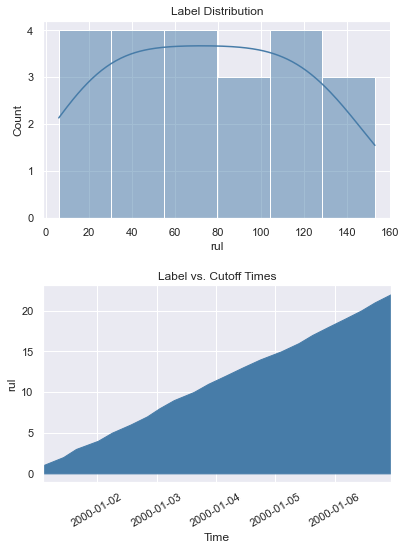

In [7]:
%matplotlib inline
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

With the continuous values, you can explore different ranges without running the search again. In this case, use quartiles to bin the values into ranges.

In [8]:
lt = lt.bin(4, quantiles=True, precision=0)

When you print out the settings again, you can now see that the description of the labels has been updated and reflects the latest changes.

In [9]:
lt.describe()

Label Distribution
------------------
(5.0, 38.0]        6
(38.0, 74.0]       5
(74.0, 111.0]      5
(111.0, 153.0]     6
Total:            22


Settings
--------
gap                                 20
minimum_data                         5
num_examples_per_instance           20
target_column                      rul
target_entity                engine_no
target_type                   discrete
window_size                       None


Transforms
----------
1. bin
  - bins:            4
  - labels:       None
  - precision:       0
  - quantiles:    True
  - right:        True



Look at the new label distribution and cumulative count across time.

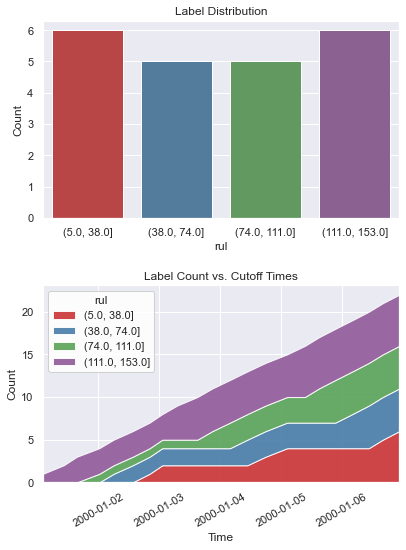

In [10]:
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

## Feature Engineering

In the previous step, you generated the labels. The next step is to generate features.

### Representing the Data

Let’s start by representing the data with an entity set. That way, you can generate features based on the relational structure of the dataset. You currently have a single table of records where one engine can have many records. This one-to-many relationship can be represented by normalizing an engine entity. The same can be done for other one-to-many relationships. Because you want to make predictions based on the engine, you should use this engine entity as the target entity for generating features.

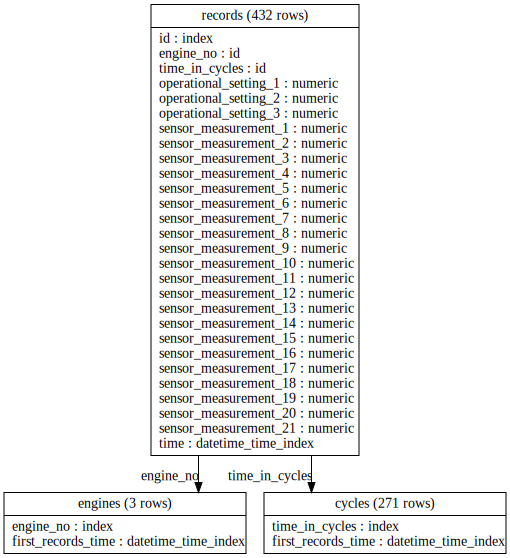

In [11]:
es = ft.EntitySet('observations')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='records',
    index='id',
    time_index='time',
)

es.normalize_entity(
    base_entity_id='records',
    new_entity_id='engines',
    index='engine_no',
)

es.normalize_entity(
    base_entity_id='records',
    new_entity_id='cycles',
    index='time_in_cycles',
)

es.plot()

### Calculating the Features

Now you can generate features by using a method called Deep Feature Synthesis (DFS). That method automatically builds features by stacking and applying mathematical operations called primitives across relationships in an entity set. The more structured an entity set is, the better DFS can leverage the relationships to generate better features. Run DFS with these parameters:

- `entity_set` as the entity set we structured previously.
- `target_entity` as the engine entity.
- `cutoff_time` as the label times that we generated previously. The label values are appended to the feature matrix.

In [15]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['sum'],
    trans_primitives=[],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

SUM(records.operational_setting_1)  \
engine_no time                                                      
1         2000-01-01 02:10:00                            144.0091   
          2000-01-01 10:20:00                            696.0567   
          2000-01-01 15:30:00                           1074.1074   
          2000-01-02 00:20:00                           1507.1531   
          2000-01-02 06:00:00                           1916.1945   

                               SUM(records.operational_setting_2)  \
engine_no time                                                      
1         2000-01-01 02:10:00                              3.1408   
          2000-01-01 10:20:00                             16.5674   
          2000-01-01 15:30:00                             26.1125   
          2000-01-02 00:20:00                             36.1607   
          2000-01-02 06:00:00                             46.6147   

                               SUM(records.operational_setting_3)  \
engine_no time                                                      
1         2000-01-01 02:10:00                               460.0   
          2000-01-01 10:20:00                              2340.0   
          2000-01-01 15:30:00                              4340.0   
          2000-01-02 00:20:00                              6300.0   
          2000-01-02 06:00:00                              8180.0   

                               SUM(records.sensor_measurement_1)  \
engine_no time                                                     
1         2000-01-01 02:10:00                            2320.65   
          2000-01-01 10:20:00                           11679.31   
          2000-01-01 15:30:00                           21363.69   
          2000-01-02 00:20:00                           30844.92   
          2000-01-02 06:00:00                           40426.89   

                               SUM(records.sensor_measurement_10)  \
engine_no time                                                      
1         2000-01-01 02:10:00                                5.29   
          2000-01-01 10:20:00                               26.46   
          2000-01-01 15:30:00                               49.45   
          2000-01-02 00:20:00                               72.28   
          2000-01-02 06:00:00                               94.48   

                               SUM(records.sensor_measurement_11)  \
engine_no time                                                      
1         2000-01-01 02:10:00                              207.99   
          2000-01-01 10:20:00                             1048.19   
          2000-01-01 15:30:00                             1932.52   
          2000-01-02 00:20:00                             2799.74   
          2000-01-02 06:00:00                             3658.46   

                               SUM(records.sensor_measurement_12)  \
engine_no time                                                      
1         2000-01-01 02:10:00                             1125.75   
          2000-01-01 10:20:00                             5771.01   
          2000-01-01 15:30:00                            12306.22   
          2000-01-02 00:20:00                            18039.10   
          2000-01-02 06:00:00                            23971.12   

                               SUM(records.sensor_measurement_13)  \
engine_no time                                                      
1         2000-01-01 02:10:00                            11579.85   
          2000-01-01 10:20:00                            58258.12   
          2000-01-01 15:30:00                           106015.78   
          2000-01-02 00:20:00                           153414.42   
          2000-01-02 06:00:00                           200093.76   

                               SUM(records.sensor_measurement_14)  \
engine_no time                                                      
1         2000-01-01 02:10:0

There are two outputs from DFS: a feature matrix and feature definitions. The feature matrix is a table that contains the feature values with the corresponding labels based on the cutoff times. Feature definitions are features in a list that can be stored and reused later to calculate the same set of features on future data.

## Machine Learning

In the previous steps, generate the labels and features. The final step is to build the machine learning pipeline.

### Splitting the Data

Start by extracting the labels from the feature matrix and splitting the data into a training set and a holdout set.

In [16]:
y = fm.pop('rul').cat.codes

splits = evalml.preprocessing.split_data(
    X=fm,
    y=y,
    test_size=0.2,
    random_state=2,
    problem_type='multiclass',
)

X_train, X_holdout, y_train, y_holdout = splits

### Finding the Best Model

Run a search on the training set to find the best machine learning model. During the search process, predictions from several different pipelines are evaluated to find the best pipeline.

In [17]:
automl = evalml.AutoMLSearch(
    X_train,
    y_train,
    problem_type='multiclass',
    objective='f1 macro',
    random_state=0,
    allowed_model_families=['catboost', 'random_forest'],
    max_iterations=3,
)

automl.search(
    data_checks='disabled',
    show_iteration_plot=False,
)

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1 Macro. 
Greater score is better.

Searching up to 3 pipelines. 
Allowed model families: random_forest, catboost

(1/3) Mode Baseline Multiclass Classificati... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.113
High coefficient of variation (cv >= 0.2) within cross validation scores. Mode Baseline Multiclass Classification Pipeline may not perform as estimated on unseen data.
(2/3) Random Forest Classifier w/ Imputer      Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.514
(3/3) CatBoost Classifier w/ Imputer           Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.611

Search finished after 00:03            
Best pipeline: CatBoost Classifier w/ Imputer
Best pipeline F1 Macro: 0.611111


Once the search is complete, you can print out information about the best pipeline found, like the parameters in each component.

**********************************
* CatBoost Classifier w/ Imputer *
**********************************

Problem Type: multiclass
Model Family: CatBoost
Number of features: 24

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. CatBoost Classifier
	 * n_estimators : 10
	 * eta : 0.03
	 * max_depth : 6
	 * bootstrap_type : None
	 * silent : True
	 * allow_writing_files : False


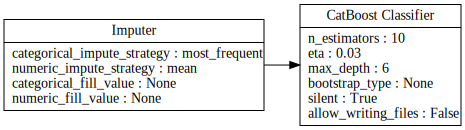

In [18]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

Score the model performance by evaluating predictions on the holdout set.

In [19]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['f1 macro'],
)

dict(score)

{'F1 Macro': 0.7}

From the pipeline, you can see which features are most important for predictions.

In [ ]:
feature_importance = best_pipeline.feature_importance
feature_importance = feature_importance.set_index('feature')['importance']
top_k = feature_importance.abs().sort_values().tail(20).index
feature_importance[top_k].plot.barh(figsize=(8, 8), fontsize=14, width=.7);

### Making Predictions

You are ready to make predictions with our trained model. Start by calculating the same set of features by using the feature definitions. Use a cutoff time based on the latest information available in the dataset.

In [ ]:
fm = ft.calculate_feature_matrix(
    features=fd,
    entityset=es,
    cutoff_time=ft.pd.Timestamp('2001-01-08'),
    cutoff_time_in_index=True,
    verbose=False,
)

fm.head()

Now predict which one of the four ranges the RUL is in.

In [ ]:
values = best_pipeline.predict(fm).values

prediction = fm[[]]
prediction['rul (estimate)'] = values
prediction.head()

### Next Steps

You have completed this tutorial. You can revisit each step to explore and fine-tune the model using different parameters until it is ready for production. For more information about how to work with the features produced by Featuretools, take a look at [the Featuretools documentation](https://docs.featuretools.com/). For more information about how to work with the models produced by EvalML, take a look at [the EvalML documentation](https://evalml.alteryx.com/).